First we need to import the useful libraries and load the data that we have previously prepared.

In [1]:
import os
import h5py
import csv
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

We also need to define a few functions useful for showing the final results.

In [2]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def residual_plot(y_true_train,y_pred_train,y_true_val,y_pred_val,directory,
                  test=False):
    title='Residual_plot'
    plt.figure(title,figsize=(10,10))
    diff_train=y_pred_train-y_true_train
    #Train and validation data
    if test==False:
        plt.scatter(y_pred_train,diff_train,c='blue',label='Train data', alpha=0.25)
        diff_val=y_pred_val-y_true_val
        plt.scatter(y_pred_val,diff_val,c='green',label='Validation data')
    #Test data
    else:
        plt.scatter(y_pred_train,diff_train,c='green',label='Test data')
        
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=min(y_pred_train),xmax=max(y_pred_train),lw=2,color='red')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    
    
def plot_regression(y_true_train,y_pred_train,y_true_val,y_pred_val,directory,
                    test=False):
    title='Real and predicted values'
    plt.figure(title,figsize=(10,10))
    #Train and validation data
    if test==False:
        plt.scatter(y_true_train,y_pred_train,c='blue',marker='o',
                    label='Train data',alpha=0.25)
        plt.scatter(y_true_val,y_pred_val,c='green',marker='x',
                    label='Validation data')
        r2_train=r2_score(y_true_train,y_pred_train)
        r2_val=r2_score(y_true_val,y_pred_val)
        plt.text(int(0.9*max(y_pred_val)),min(y_true_val),
             'R2_score_val = '+str(round(r2_val,3))+
             '\nR2_score_train = '+str(round(r2_train,3)),
             color='red')
    #Test data
    else:
        plt.scatter(y_true_train,y_pred_train,c='green',marker='x',
                    label='Test data')
        r2_test=r2_score(y_true_train,y_pred_train)
        plt.text(int(0.9*max(y_pred_train)),min(y_true_train),
             'R2_score_test = '+str(round(r2_test,3)),
             color='red')
    
    plt.xlabel('Predicted values (yield)')
    plt.ylabel('Real values (yield)')
    plt.legend(loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    

def plot_average_losses(history_list,directory, bias=0):
    
    all_val_loss=[]
    all_val_mean_absolute_error=[]
    all_loss=[]
    all_mean_absolute_error=[]
    for hst in history_list:
        val_loss=hst.history['val_loss']
        all_val_loss.append(val_loss)
        
        val_mean_absolute_error=hst.history['val_mae']
        all_val_mean_absolute_error.append(val_mean_absolute_error)
        
        loss=hst.history['loss']
        all_loss.append(loss)
        
        mean_absolute_error=hst.history['mae']
        all_mean_absolute_error.append(mean_absolute_error)
    
    len_list=[]
    for length in range(len(all_loss)):
        len_list.append(len(all_loss[length]))
        
    num_epochs=min(len_list)
    
    average_val_loss=[np.mean(
            [x[i] for x in all_val_loss]) for i in range(num_epochs)]
    average_val_mean_absolute_error=[np.mean(
            [x[i] for x in all_val_mean_absolute_error]) for i in range(num_epochs)]
    average_loss=[np.mean(
            [x[i] for x in all_loss]) for i in range(num_epochs)]
    average_mean_absolute_error=[np.mean(
            [x[i] for x in all_mean_absolute_error]) for i in range(num_epochs)]
    
    smoothed_average_val_loss=smooth_curve(average_val_loss[bias:]) 
    smoothed_average_val_mean_absolute_error=smooth_curve(
            average_val_mean_absolute_error[bias:])
    smoothed_average_loss=smooth_curve(average_loss[bias:])
    smoothed_average_mean_absolute_error=smooth_curve(
            average_mean_absolute_error[bias:])
    
    title='Training_and_validation_loss'
    plt.figure(title,figsize=(10,7))
    plt.plot(smoothed_average_loss)
    plt.plot(smoothed_average_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(axis='y')
    plt.legend(['train', 'validation'], loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    
    title='Training_and_validation_error'
    plt.figure(title,figsize=(10,7))
    plt.plot(smoothed_average_mean_absolute_error)
    plt.plot(smoothed_average_val_mean_absolute_error)
    plt.title('model error')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.grid(axis='y')
    plt.legend(['train', 'validation'], loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()

Now we load the data and labels.

In [3]:
#Load data and labels
print('\nLoading data...')
project_dir='/your/project/'
data_dir=os.path.join(project_dir,'data')
saving_dir=os.path.join(project_dir,'results','LSTM')
string_dir='mkdir -p '+saving_dir
os.system(string_dir)

#Tabular data
file_name_h5 = os.path.join(data_dir, 'tabular_data.h5')
h5f = h5py.File(file_name_h5,'r')
X_tab = h5f['dataset_tab'][:]
h5f.close()

#Sequential data
file_name_h5 = os.path.join(data_dir, 'sequential_data.h5')
h5f = h5py.File(file_name_h5,'r')
X_seq = h5f['dataset_seq'][:]
h5f.close()
X_seq=np.nan_to_num(X_seq)

y_list=[]
file_name_txt = os.path.join(data_dir, 'labels.txt')
file = open(file_name_txt,"r") 
for line in file:
    y_list.append(line.strip())
y=np.asarray(y_list).astype(np.float64)
y=y/0.03527396195#grams

print('Samples loaded successfully:',X_tab.shape, X_seq.shape)
print('Labels loaded successfully:',y.shape)


Loading data...
Samples loaded successfully: (200, 10) (200, 4431, 8)
Labels loaded successfully: (200,)


This is the two-headed LSTM-based model that we have used for our work.

In [4]:
# Create model
# Tabular input
input_tab=Input(shape=(X_tab.shape[1],),name='tabular')
branch_x=Dense(48,activation='relu')(input_tab)
branch_x=Dense(48,activation='relu')(branch_x)
branch_x=Dense(48,activation='relu')(branch_x)

# #Sequential model
input_seq=Input(shape=(X_seq.shape[1],X_seq.shape[2]),name='sequential')
branch_y=LSTM(20,return_sequences=True)(input_seq)
branch_y=LSTM(30,return_sequences=True)(branch_y)
branch_y=Flatten()(branch_y)

#Common regressor
reg=concatenate([branch_x,branch_y])
reg=Dense(120,activation='relu')(reg)
reg=Dense(84,activation='relu')(reg)
output=Dense(1,activation='relu')(reg)#linear

model=Model([input_tab,input_seq],output)

model.compile(optimizer='adadelta',loss='mse',metrics=['mae','mse'])
print("\nModel created successfully!\n")


Model created successfully!



In this example, we will train the model for only 5 epochs, due to computational load. However, the values shown in the code are the ones we used in our model.

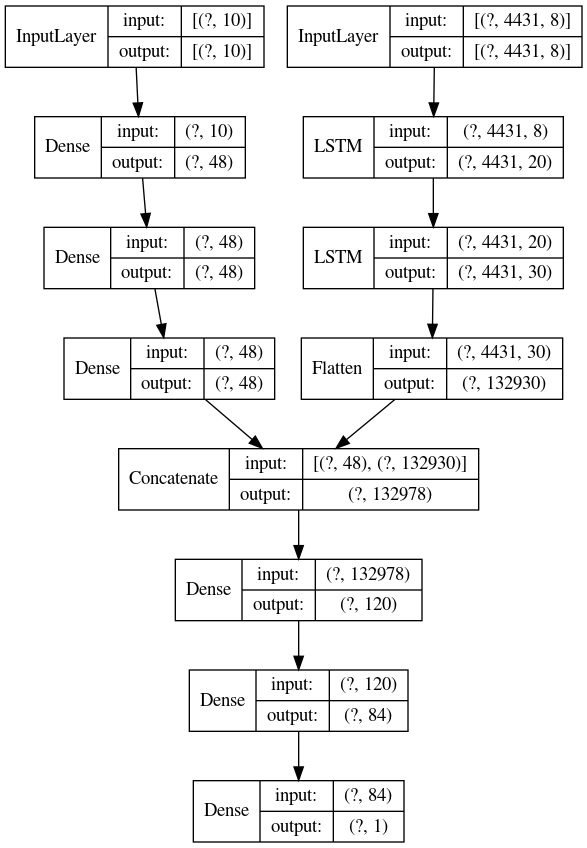

In [5]:
#Model conditions
epochs=1500
batch_size=20
#epochs one tenth of CNN, batch size of validation data set

callbacks_list=[ModelCheckpoint(os.path.join(saving_dir,'model_lstm.h5'),
                                save_best_only=False)]

#Plot model
plot_model(model,to_file=os.path.join(saving_dir,'network_model_lstm.png'),
           show_shapes = True,show_layer_names = False)

Now we train the model with repeated k-fold cross validation.

In [6]:
#Training the model
kf= RepeatedKFold(n_splits=10,n_repeats=5,random_state=42)# 5 times DL - no grid search
mmsc=MinMaxScaler()

y_train=[]
y_val=[]
train_pred=[]
val_pred=[]
mse_train_results=[]
mse_val_results=[]
me_train_results=[]
me_val_results=[]
r2_train_results=[]
r2_val_results=[]
all_history=[]

i=1

init_time=datetime.datetime.now()
print('Model starts training at:',init_time) 

for train, val in kf.split(X_seq,y): 
    
    print('\nTraining fold: ',i)
    
    y_train.append(y[train])
    y_val.append(y[val])
    
    X_train_tab=mmsc.fit_transform(X_tab[train])
    X_val_tab=mmsc.transform(X_tab[val])
    
    X_train_seq=X_seq[train]
    X_val_seq=X_seq[val]
    
    X_tr_sq_ur=np.reshape(X_train_seq,(X_train_seq.shape[0]*X_train_seq.shape[1],
                                        X_train_seq.shape[2]))
    
    X_vl_sq_ur=np.reshape(X_val_seq,(X_val_seq.shape[0]*X_val_seq.shape[1],
                                        X_val_seq.shape[2]))
    
    X_tr_sq=mmsc.fit_transform(X_tr_sq_ur)
    X_vl_sq=mmsc.transform(X_vl_sq_ur)
    
    X_train_seq=np.reshape(X_tr_sq,(X_train_seq.shape[0],X_train_seq.shape[1],
                                        X_train_seq.shape[2]))
    
    X_val_seq=np.reshape(X_vl_sq,(X_val_seq.shape[0],X_val_seq.shape[1],
                                        X_val_seq.shape[2]))
    
    
    history=model.fit({'tabular':X_train_tab,'sequential':X_train_seq},y[train],
                      batch_size=batch_size, epochs=epochs,
                      verbose=False, validation_data=(
                          {'tabular':X_val_tab,'sequential':X_val_seq},
                          y[val]))
    
    all_history.append(history)
    
    y_train_pred=model.predict({'tabular':X_train_tab,'sequential':X_train_seq})
    y_val_pred=model.predict({'tabular':X_val_tab,'sequential':X_val_seq})
    train_pred.append(y_train_pred)
    val_pred.append(y_val_pred)
    
    mse_train=mean_squared_error(y[train],y_train_pred)
    mse_val=mean_squared_error(y[val],y_val_pred)
    mse_train_results.append(mse_train)
    mse_val_results.append(mse_val)
    
    me_train=mean_absolute_error(y[train],y_train_pred)
    me_val=mean_absolute_error(y[val],y_val_pred)
    me_train_results.append(me_train)
    me_val_results.append(me_val)
    
    r2_train=r2_score(y[train],y_train_pred)
    r2_val=r2_score(y[val],y_val_pred)
    r2_train_results.append(r2_train)
    r2_val_results.append(r2_val)
    
    i+=1

end_time=datetime.datetime.now()
print('\n\nTuning finishes at:',end_time)
print('Total duration of model tuning:',end_time-init_time)

Model starts training at: 2021-06-24 14:31:58.526488

Training fold:  1

Training fold:  2

Training fold:  3

Training fold:  4

Training fold:  5

Training fold:  6

Training fold:  7

Training fold:  8

Training fold:  9

Training fold:  10

Training fold:  11

Training fold:  12

Training fold:  13

Training fold:  14

Training fold:  15

Training fold:  16

Training fold:  17

Training fold:  18

Training fold:  19

Training fold:  20

Training fold:  21

Training fold:  22

Training fold:  23

Training fold:  24

Training fold:  25

Training fold:  26

Training fold:  27

Training fold:  28

Training fold:  29

Training fold:  30

Training fold:  31

Training fold:  32

Training fold:  33

Training fold:  34

Training fold:  35

Training fold:  36

Training fold:  37

Training fold:  38

Training fold:  39

Training fold:  40

Training fold:  41

Training fold:  42

Training fold:  43

Training fold:  44

Training fold:  45

Training fold:  46

Training fold:  47

Training fold: 

The model has been trained only for a few epochs, so the results are not the ones achived in the presented work, but the goal of showing the process is accomplished.

In [7]:
print('Results:')
for i in range(len(mse_train_results)):
    print('\nK-fold: ',i+1)
    print('MSE train: {0:.3f}   MSE validation: {1:.3f}'.format(mse_train_results[i],
          mse_val_results[i]))
    print('MAE train: {0:.3f}   MAE validation: {1:.3f}'.format(me_train_results[i],
          me_val_results[i]))
    print('r^2 train: {0:.3f}   r^2 validation: {1:.3f}'.format(r2_train_results[i],
          r2_val_results[i]))

mse_avg_train=np.mean(mse_train_results)
mae_avg_train=np.mean(me_train_results)
r2_avg_train=np.mean(r2_train_results)

mse_avg_val=np.mean(mse_val_results)
mae_avg_val= np.mean(me_val_results)
r2_avg_val=np.mean(r2_val_results)

print('\nMean values (and standard deviation) over the entire dataset:')    
print('MSE train: {0:.3f} ({1:.3f})  MSE validation: {2:.3f} ({3:.3f})'.format(
    mse_avg_train,np.std(mse_train_results),
              mse_avg_val,np.std(mse_val_results)))
print('MAE train: {0:.3f} ({1:.3f})  MAE validation: {2:.3f} ({3:.3f})'.format(
    mae_avg_train,np.std(me_train_results),
              mae_avg_val,np.std(me_val_results)))
print('r^2 train: {0:.3f} ({1:.3f})  r^2 validation: {2:.3f} ({3:.3f})'.format(
    r2_avg_train,np.std(r2_train_results),
              r2_avg_val,np.std(r2_val_results)))

Results:

K-fold:  1
MSE train: 544.868   MSE validation: 1200.889
MAE train: 13.299   MAE validation: 19.784
r^2 train: -0.430   r^2 validation: -0.452

K-fold:  2
MSE train: 524.138   MSE validation: 712.169
MAE train: 12.625   MAE validation: 16.271
r^2 train: -0.250   r^2 validation: -0.410

K-fold:  3
MSE train: 473.491   MSE validation: 183.186
MAE train: 12.495   MAE validation: 9.264
r^2 train: -0.042   r^2 validation: 0.004

K-fold:  4
MSE train: 386.991   MSE validation: 163.377
MAE train: 12.799   MAE validation: 9.885
r^2 train: 0.148   r^2 validation: 0.097

K-fold:  5
MSE train: 351.739   MSE validation: 312.238
MAE train: 13.003   MAE validation: 13.447
r^2 train: 0.188   r^2 validation: 0.219

K-fold:  6
MSE train: 365.387   MSE validation: 144.380
MAE train: 13.459   MAE validation: 10.405
r^2 train: 0.211   r^2 validation: -1.938

K-fold:  7
MSE train: 346.809   MSE validation: 277.792
MAE train: 13.008   MAE validation: 14.711
r^2 train: 0.221   r^2 validation: -0.01

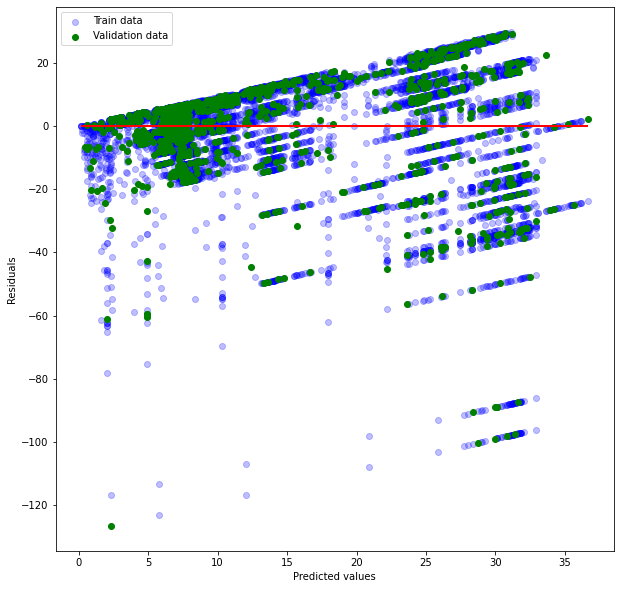

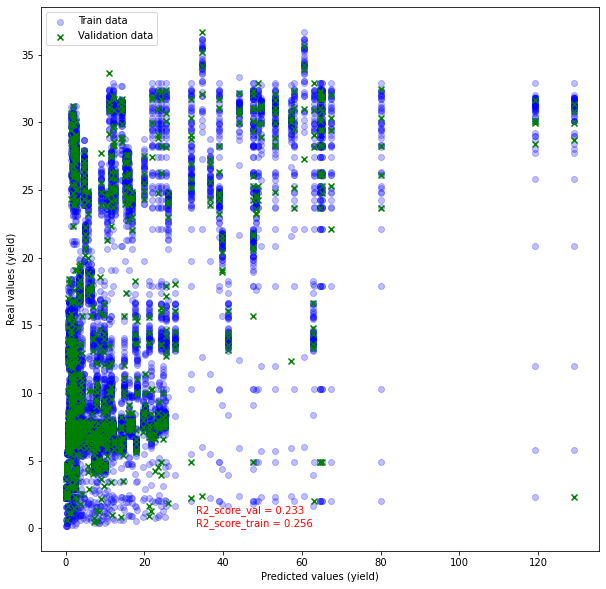

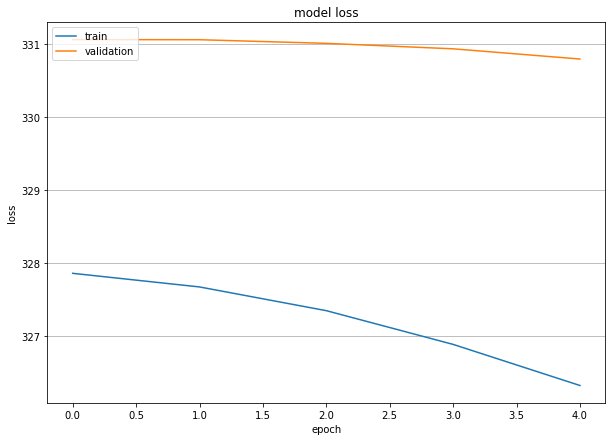

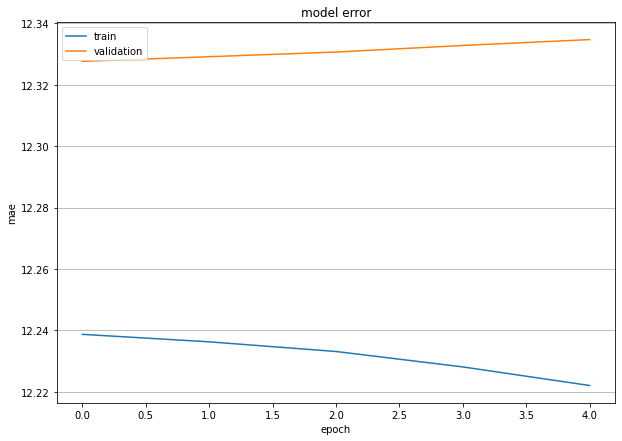

In [8]:
#Results as plots
residual_plot(np.concatenate(y_train),np.concatenate(train_pred)[:,0],
              np.concatenate(y_val),np.concatenate(val_pred)[:,0],saving_dir)

plot_regression(np.concatenate(y_train),np.concatenate(train_pred)[:,0],
              np.concatenate(y_val),np.concatenate(val_pred)[:,0],saving_dir)

plot_average_losses(all_history,saving_dir, bias=0)

The training and validation losses tend to decrease for the real scenario.

The previous process was useful for obtaining the metrics of the prediction capabilities of our model, which are presenten in this table. However, for the next stage, which is the analysis of the features that contribute to the predictions, we retrained the model, using all the available data.

| ML model | MSE train | MSE val | MAE train | MAE val | R2 train | R2 val |
|----------|-----------|---------|-----------|---------|----------|--------|
|   LSTM   |   50.557  |  72.815 |   3.933   |  4.853  |  0.881   |  0.735 |

In [9]:
#Train and save the final model
X_tab=mmsc.fit_transform(X_tab)
X_seq=X_seq

init_time=datetime.datetime.now()
print('Model starts training at:',init_time) 
trained_model=model.fit({'tabular':X_tab,'sequential':X_seq},y,
                        batch_size=batch_size, epochs=epochs,
                        verbose=True,callbacks=callbacks_list)
end_time=datetime.datetime.now()
print('\n\nModel finishes training at:',end_time)
total_time=end_time-init_time
print('Total duration of model training:',total_time)

print("\nTraining finished correctly!\n")
print('Model saved correctly!')

Model starts training at: 2021-06-24 14:46:38.404425
Train on 200 samples
Epoch 1/5
200/200 [==============================] - 3s 14ms/sample - loss: 387.0918 - mae: 11.5082 - mse: 387.0918
Epoch 2/5
200/200 [==============================] - 2s 12ms/sample - loss: 360.5698 - mae: 11.5113 - mse: 360.5699
Epoch 3/5
200/200 [==============================] - 2s 12ms/sample - loss: 345.1659 - mae: 11.5742 - mse: 345.1659
Epoch 4/5
200/200 [==============================] - 2s 12ms/sample - loss: 335.5427 - mae: 11.6442 - mse: 335.5427
Epoch 5/5
200/200 [==============================] - 2s 12ms/sample - loss: 328.6156 - mae: 11.6731 - mse: 328.6156


Model finishes training at: 2021-06-24 14:46:50.598833
Total duration of model training: 0:00:12.194408

Training finished correctly!

Model saved correctly!


In [10]:
#Writing to CSV
file_summary=os.path.join(saving_dir,'results_summary_lstm.csv')

with open(file_summary, 'w', newline='') as csvfile:
    results = csv.writer(csvfile, delimiter=',')
    results.writerow(['Values over the entire dataset (metrics):'])
    results.writerow(['MSE train:'])
    results.writerow([mse_avg_train])
    results.writerow(['MSE validation:'])
    results.writerow([mse_avg_val])
    results.writerow(['MAE train:'])
    results.writerow([mae_avg_train])
    results.writerow(['MAE validation:'])
    results.writerow([mae_avg_val])
    results.writerow(['r^2 train:'])
    results.writerow([r2_avg_train])
    results.writerow(['r^2 validation:'])
    results.writerow([r2_avg_val])
    results.writerow(['Total training time:'])
    results.writerow([total_time])

print("\nResults generated correctly!\n")

print("\nJob finished! =) \n")


Results generated correctly!


Job finished! =) 

